# Домашнее задание 6: классификация текстов

В этом домашнем задании вам предстоит построить классификатор текстов!

Данные мы будем использовать из Kaggle соревнования: https://www.kaggle.com/competitions/nlp-getting-started/data 


Оттуда надо скачать файл train.csv. На обучающую и тестовую выборки его поделим кодом ниже, менять его не надо!

Мы будем работать с датасетом постов из твиттера. Нам предстоит решать задачу бинарной классификации - определять содержатся ли в твитте информация о настоящей катастрофе/инциденте или нет.

In [63]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, \
HashingVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import TweetTokenizer, word_tokenize
from nltk.corpus import stopwords
import re
import string

In [64]:
data = pd.read_csv('train.csv')

In [65]:
data

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


## Задание 1 (0.5 балла)

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их пустой строкой.

In [66]:
data.isna().any().any()

True

In [67]:
data = data.fillna('')
data.isna().any().any()

False

In [68]:
train, test = train_test_split(data, test_size=0.3, random_state=42)

## Задание 2 (1 балл)
Давайте немного посмотрим на наши данные. Визуализируйте (где явно просят) или выведете информацию о следующем:

1. Какое распределение классов в обучающей выборке?


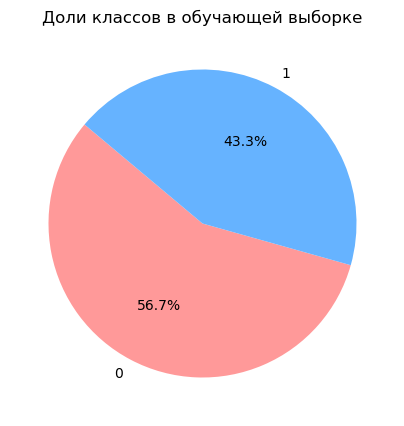

In [69]:
class_counts = train['target'].value_counts()

plt.figure(figsize=(5, 5))
plt.pie(class_counts, labels=class_counts.index,
        autopct='%1.1f%%', startangle=140,
        colors=['#ff9999','#66b3ff','#99ff99','#ffcc99'])
plt.title('Доли классов в обучающей выборке')
plt.axis()
plt.show()

2. Посмотрите на колонку "keyword" - возьмите 10 наиболее встречающихся значений, постройте ступенчатую диаграмму распределения классов в зависимости от значения keyword, сделайте выводы.

In [70]:
popular_keywords = train['keyword'].value_counts().sort_values(ascending=False)[:10]
popular_keywords_mask = train['keyword'].isin(list(popular_keywords.index))
popular_keywords

keyword
                     44
damage               36
siren                35
wreckage             34
fatalities           33
deluge               31
emergency            30
harm                 30
twister              30
nuclear%20reactor    30
Name: count, dtype: int64

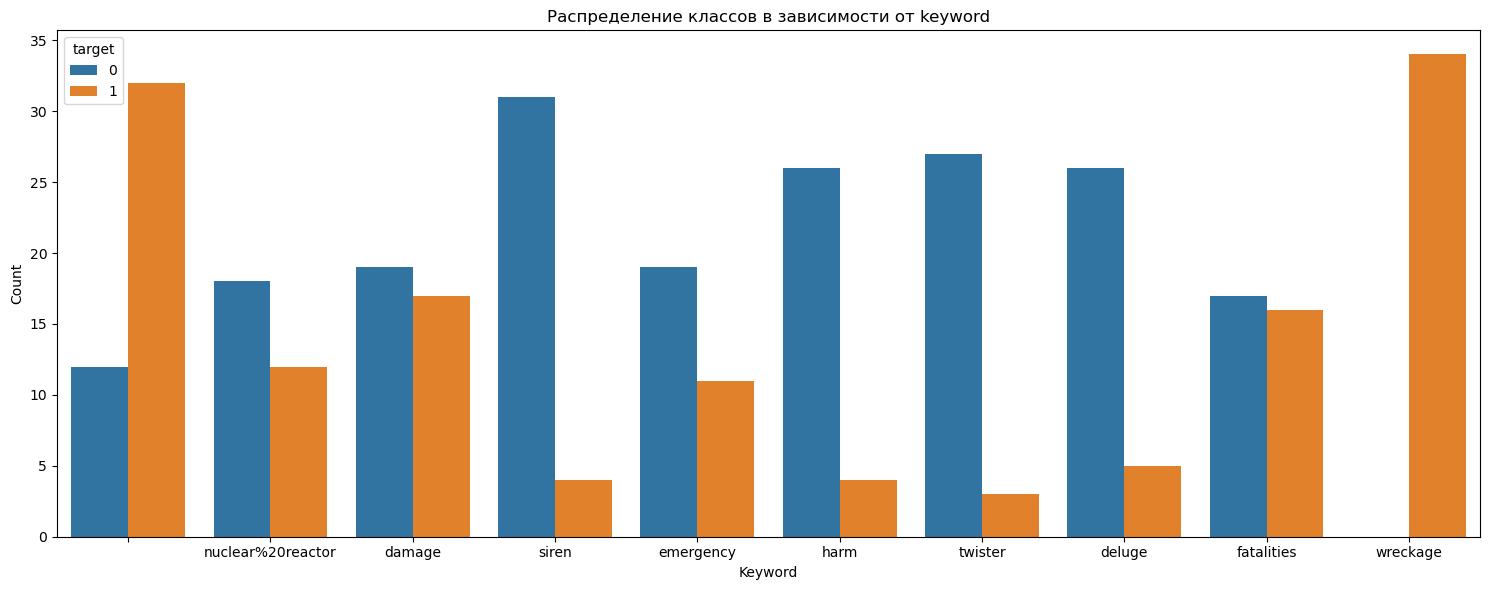

In [71]:
plt.figure(figsize=(15, 6))

sns.countplot(data=train[['target', 'keyword']][popular_keywords_mask],
              x='keyword', hue='target', legend='brief')

plt.xlabel('Keyword')
plt.ylabel('Count')
plt.title('Распределение классов в зависимости от keyword')
plt.xticks()
plt.tight_layout()
plt.show()

**Выводы**: Среди твитов со значениями параметра `keyword` siren, emergency, harm, twister, deluge заметно преобладает класс 0, среди твитов с пропущенным значением параметра `keyword` и со значением `keyword` = wreckage заметно преобладает класс 1. Таким образом, можно сделать вывод, что тип твита сильно коррелирован со значением параметра `keyword`.

## Задание 3 (0.5 балла) 

В этом задании предлагается объединить все три текстовых столбца в один (просто сконкатенировать cтроки) и убрать столбец с индексом.

In [72]:
train.loc[[6590, 7122, 2769]]

,id,keyword,location,text,target
6590,9436,survivors,"Marietta, GA",Stemming from my #Cubs talk- the team rosters ...,1
7122,10203,violent%20storm,,If you were the NWS wth a rotating storm w/ a ...,1
2769,3980,devastation,Atlanta g.a.,http://t.co/Gxgm1T3W0J From Devastation to Ela...,0


In [73]:
train['text'] = train['keyword'].str.cat([train['location'], train['text']], sep=' ')
train_new = train.drop(columns=['id', 'keyword', 'location'])
train_new.loc[[6590, 7122, 2769]]

,text,target
6590,"survivors Marietta, GA Stemming from my #Cubs ...",1
7122,violent%20storm If you were the NWS wth a rot...,1
2769,devastation Atlanta g.a. http://t.co/Gxgm1T3W0...,0


## Задание 4 (0.5 балла)

Далее мы будем пока работать только с train частью.

1. Предобработайте данные (train часть) с помощью CountVectorizer.
2. Какого размера получилась матрица?


In [74]:
cnt_vec = CountVectorizer()
train_vectorized = cnt_vec.fit_transform(train['text'])

In [75]:
print(f'Размер матрицы признаков после обработки CountVectorizer: {train_vectorized.toarray().shape}')

Размер матрицы признаков после обработки CountVectorizer: (5329, 18455)


## Задание 5 (1 балл)

В предыдущем пункте у вас должна была получиться достаточно большая матрица.
Если вы взгляните на текст, то увидете, что там есть множество специальных символов, ссылок и прочего мусора.

Давайте также посмотрим на словарь, который получился в результате построения CountVectorizer, его можно найти в поле vocabulary_ инстанса этого класса. Давайте напишем функцию, которая печает ответы на следующие вопросы:

1. Найдите в этом словаре все слова, которые содержат цифры. Сколько таких слов нашлось?

2. Найдите все слова, которые содержат символы пунктуации. Сколько таких слов нашлось? 

3. Сколько хэштегов (токен начинается на #) и упоминаний (токен начинается на @) осталось в словаре?

In [76]:
def contains_digit(s: str) -> bool:
    # Проверка, содержит ли слово цифры
    return bool(re.search(r'\d', s))

def contains_punctuation(s: str) -> bool:
    # Проверка, содержит ли слово пунктуацию
    pattern = fr'[{re.escape(string.punctuation)}]'
    return bool(re.search(pattern, s))

def is_hashtag(s: str) -> bool:
    # Проверка, является ли слово хэштегом
    pattern = r'^#[\w]+$'
    return bool(re.match(pattern, s))

def is_mention(s: str) -> bool:
    # Проверка, является ли слово упоминанием
    pattern = r'^@[\w]+$'
    return bool(re.match(pattern, s))

def investigate_vocabulary(vocabulary):
    keys = vocabulary.keys()
    num_words_digits = np.sum(list(map(lambda s: contains_digit(s), keys)))
    num_words_punc = np.sum(list(map(lambda s: contains_punctuation(s), keys)))
    num_words_hashtag = np.sum(list(map(lambda s: is_hashtag(s), keys)))
    num_words_mention = np.sum(list(map(lambda s: is_mention(s), keys)))
    print('With digit:      ', num_words_digits
          )
    print('With punctuation:', num_words_punc
          )
    print('Hashtags:        ', num_words_hashtag
          )
    print('Mentions:        ', num_words_mention
          )
    print('Total lengths:   ', len(keys)
          )




In [77]:
dummy_vocab = {'th1nk' : 0,
               'think333' : 1,
               'think.' : 2,
               'th!nk' : 3,
               'th...nk' : 4,
               '#think' : 5,
               '@think' : 6,
               '@thinking':7,
               '@nothink' : 8,
               'think' : 9}
investigate_vocabulary(dummy_vocab)

With digit:       2
With punctuation: 7
Hashtags:         1
Mentions:         3
Total lengths:    10


In [78]:
investigate_vocabulary(cnt_vec.vocabulary_
                       )

With digit:       3812
With punctuation: 315
Hashtags:         0
Mentions:         0
Total lengths:    18455


## Задание 6 (0.5 балла)

Вспомним, что на семинаре по текстам мы узнали, что в nltk есть специальный токенизатор для текстов - TweetTokenizer. Попробуем применить CountVectorizer с этим токенизатором. Ответьте на все вопросы из предыдущего пункта для TweetTokenizer и сравните результаты.

In [79]:
tweet_tokenizer = TweetTokenizer()
cnt_vec_tweet_tknzr = CountVectorizer(tokenizer=tweet_tokenizer.tokenize, stop_words=stopwords.words('english'))
train_vectorized = cnt_vec_tweet_tknzr.fit_transform(train['text'])

c:\Users\Mi\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [80]:
print(f'Размер матрицы признаков после обработки CountVectorizer с использованием TweetTokenizer: \
{train_vectorized.toarray().shape}')

Размер матрицы признаков после обработки CountVectorizer с использованием TweetTokenizer: (5329, 19510)


In [81]:
investigate_vocabulary(cnt_vec_tweet_tknzr.vocabulary_
                       )

With digit:       3939
With punctuation: 7317
Hashtags:         1453
Mentions:         1678
Total lengths:    19510


**Сравнение:** При использовании TweetTokenizer увеличилось общее число токенов, а также количество токенов, содержащих хештеги и упоминания. Отсюда можно сделать выводы, что TweetTokenizer хештеги и упоминания выделяет в отдельные токены.

## Задание 7 (2 балла)

В scikit-learn мы можем оценивать процесс подсчета матрицы через CountVectorizer. У CountVectorizer, как и у других наследников \_VectorizerMixin, есть аргумент tokenizer и preprocessor. preprocessor применится в самом начале к каждой строке вашего датасета, tokenizer же должен принять строку и вернуть токены.
Давайте напишем кастомный токенайзер, которые сделает все, что нам нужно: 

0. Приведет все буквы к нижнему регистру
1. Разобьет текст на токены с помощью TweetTokenizer из пакета nltk
2. Удалит все токены содержащие не латинские буквы, кроме смайликов (будем считать ими токены содержащие только пунктуацию и, как минимум, одну скобочку) и хэштегов, которые после начальной # содержат только латинские буквы.
3. Удалит все токены, которые перечислены в nltk.corpus.stopwords.words('english')
4. Проведет стемминг с помощью SnowballStemmer



In [82]:
nltk.download("stopwords", quiet=True)
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [83]:
def contains_only_latin_letters(s: str) -> bool:
    # Проверка, содержит ли слово только латинские буквы
    return s.isalpha()

def is_emoji(s: str) -> bool:
    # Проверка, является ли слово смайликом
    punctuation_pattern = fr'^[{re.escape(string.punctuation)}]+$'
    brackets_pattern = r'[()]' 
    if re.fullmatch(punctuation_pattern, s):
        return bool(re.search(brackets_pattern, s))
    return False

def is_hashtag(s: str) -> bool:
    # Проверка, является ли слово хэштегом
    pattern = r'^#[\w]+$'
    return bool(re.match(pattern, s))

stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')
tknzr = TweetTokenizer()

def custom_tokenizer(s: str) -> List[str]:
    """
    Custom tokenizer that tokenizes input text,
    removes stopwords, filters by specific criteria,
    and stems the remaining tokens.
    
    :param s: Input string to tokenize
    :return: List of processed tokens
    """
    s = s.lower()

    tokens = tknzr.tokenize(s)

    filtered_tokens = []
    
    for token in tokens:
        if (contains_only_latin_letters(token) or
            is_emoji(token) or
            is_hashtag(token)):
            
            if token not in stop_words:
                stemmed_token = stemmer.stem(token)
                filtered_tokens.append(stemmed_token)

    return filtered_tokens

            
  

In [84]:
custom_tokenizer('She LOVES painting :-) #art')

['love', 'paint', ':-)', '#art']

Продемонстрируйте работу вашей функции на первых десяти текстах в обучающей выборке.

In [85]:
for i, s in enumerate(train_new['text'][:10]):
    print(f'{i + 1}) {custom_tokenizer(s)}')

1) ['bridg', 'ash', 'australia', 'ûªs', 'collaps', 'trent', 'bridg', 'among', 'worst', 'histori', 'england', 'bundl', 'australia']
2) ['hail', 'carol', 'stream', 'illinoi', 'great', 'michigan', 'techniqu', 'camp', 'thank', '#goblu', '#wrestleon']
3) ['polic', 'houston', 'cnn', 'tennesse', 'movi', 'theater', 'shoot', 'suspect', 'kill', 'polic']
4) ['riot', 'still', 'riot', 'coupl', 'hour', 'left', 'class']
5) ['wound', 'lake', 'highland', 'crack', 'path', 'wipe', 'morn', 'beach', 'run', 'surfac', 'wound', 'left', 'elbow', 'right', 'knee']
6) ['airplan', 'somewher', 'expert', 'franc', 'begin', 'examin', 'airplan', 'debri', 'found', 'reunion', 'island', 'french', 'air', 'accid', 'expert', '#mlb']
7) ['bloodi', 'isol', 'citi', 'world', 'perth', 'came', 'kill', 'indian', 'fun', 'video', 'smirk', 'remorseless', 'pakistani', 'killer', 'show', 'boast']
8) ['burn', 'except', 'idk', 'realli', 'burn']
9) ['destroy', '(', 'ask', ')', 'destroy', 'hous']
10) ['wound', 'maracay', 'nirgua', 'venezuela

## Задание 8 (1 балл)

1. Примените CountVectorizer с реализованным выше токенизатором к обучающим и тестовым выборкам.


In [86]:
test['text'] = test['keyword'].str.cat([test['location'], test['text']], sep=' ')
test_new = test.drop(columns=['id', 'keyword', 'location'])
test_new.head(3)

,text,target
2644,destruction So you have a new weapon that can...,1
2227,deluge The f$&amp;@ing things I do for #GISHW...,0
5448,police UK DT @georgegalloway: RT @Galloway4May...,1


In [87]:
vectorizer = CountVectorizer(tokenizer=custom_tokenizer)
full_train_vectorized = vectorizer.fit_transform(train_new['text'])
full_test_vectorized = vectorizer.transform(test_new['text'])

c:\Users\Mi\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [88]:
full_test_vectorized.toarray().shape

(2284, 10696)

2. Обучите LogisticRegression на полученных признаках.


In [89]:
logistic_regressor = LogisticRegression()

logistic_regressor.fit(full_train_vectorized, train_new['target'].to_numpy())
pred_targets = logistic_regressor.predict(full_test_vectorized)
true_targets = test_new['target'].to_numpy()

3. Посчитайте метрику f1-score на тестовых данных.

In [90]:
print(f'F1 = {f1_score(true_targets, pred_targets)}')

F1 = 0.7524219590958019


## Задание 9 (1 балл)

1. Повторите 8 задание, но с tf-idf векторизатором. Как изменилось качество?


In [91]:
tf_idf_vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer)
full_train_vectorized = tf_idf_vectorizer.fit_transform(train_new['text'])
full_test_vectorized = tf_idf_vectorizer.transform(test_new['text'])
full_test_vectorized.toarray().shape

c:\Users\Mi\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(2284, 10696)

In [92]:
logistic_regressor.fit(full_train_vectorized, train_new['target'].to_numpy())
pred_targets = logistic_regressor.predict(full_test_vectorized)
true_targets = test_new['target'].to_numpy()

print(f'F1 = {f1_score(true_targets, pred_targets)}')

F1 = 0.7430478309232482


1. **Ответ:** Качество незначительно снизилось

2. Мы можем еще сильнее уменьшить размер нашей матрицы, если отбросим значения df близкие к единице. Скорее всего такие слова не несут много информации о категории, так как встречаются достаточно часто. Ограничьте максимальный df в параметрах TfIdfVectorizer, поставьте верхнюю границу равную 0.9. Как изменился размер матрицы, как изменилось качество?


In [93]:
tf_idf_vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer, max_df=0.9)
full_train_vectorized = tf_idf_vectorizer.fit_transform(train_new['text'])
full_test_vectorized = tf_idf_vectorizer.transform(test_new['text'])
full_test_vectorized.toarray().shape

c:\Users\Mi\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(2284, 10696)

In [94]:
logistic_regressor.fit(full_train_vectorized, train_new['target'].to_numpy())
pred_targets = logistic_regressor.predict(full_test_vectorized)
true_targets = test_new['target'].to_numpy()

print(f'F1 = {f1_score(true_targets, pred_targets)}')

F1 = 0.7430478309232482


2. **Ответ:** Размер матрицы не изменился, поэтому можно сделать вывод о том, что в датасете нет токенов, которые встречаются более чем в 90% документов.

3. Также мы можем уменьшить размер матрицы, удаляя слова со слишком маленьким df. Удалось ли добиться улучшения качества? 

In [95]:
tf_idf_vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer, min_df=5 * 1e-4)
full_train_vectorized = tf_idf_vectorizer.fit_transform(train_new['text'])
full_test_vectorized = tf_idf_vectorizer.transform(test_new['text'])
full_test_vectorized.toarray().shape

c:\Users\Mi\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(2284, 3161)

In [96]:
logistic_regressor.fit(full_train_vectorized, train_new['target'].to_numpy())
pred_targets = logistic_regressor.predict(full_test_vectorized)
true_targets = test_new['target'].to_numpy()

print(f'F1 = {f1_score(true_targets, pred_targets)}')

F1 = 0.7441860465116279


3. **Ответ:** Уменьшение размеров матрицы путем настройки параметра `min_df` не приводит к улучшению целевой метрики. Стоит отметить, что настройка `min_df` позволяет значительно уменьшить размер матрицы и при этом не приводит к значительным потерям качества.

## Задание 10 (1 балл)

Еще один популяпный трюк, который позволит уменьшить количество признаков называется hashing trick. Его суть в том, то мы случайно группируем признаки ииии  ..... складываем их! А потом удаляем исходные признаки. В итоге все наши признаки это просто суммы исходных. Звучит странно, но это отлично работает. Давайте проверим этот трюк в нашем сеттинге.
Также при таком подходе вам не нужно хранить словарь token->index, что тоже иногда полезно.

1. Повторите задание 8 с HashingVectorizer, укажите количество фичей равное 5000.


In [97]:
hashing_vectorizer = HashingVectorizer(tokenizer=custom_tokenizer, n_features=40000)

full_train_vectorized = hashing_vectorizer.fit_transform(train_new['text'])
full_test_vectorized = hashing_vectorizer.transform(test_new['text'])
full_test_vectorized.toarray().shape

c:\Users\Mi\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(2284, 40000)

In [98]:
logistic_regressor.fit(full_train_vectorized, train_new['target'].to_numpy())
pred_targets = logistic_regressor.predict(full_test_vectorized)
true_targets = test_new['target'].to_numpy()

print(f'F1 = {f1_score(true_targets, pred_targets)}')

F1 = 0.736783528102393


2. Какой из подходов показал самый высокий результат?

2. **Ответ:** Наилучшее значение F1-score достигается при использовании `CountVectorizer()`

## Задание 11 (1 балл)

В этом задании нужно добиться f1 меры хотя в 0.75 на тестовых данных.

In [99]:
full_train_data = data
full_train_data.fillna('', inplace=True)
full_train_data['text'] = full_train_data['keyword'].str.cat([full_train_data['location'], full_train_data['text']], sep=' ')
full_train_data.drop(columns=['keyword', 'location'], inplace=True)

full_test_data = pd.read_csv('test.csv')
full_test_data.fillna('', inplace=True)
full_test_data['text'] = full_test_data['keyword'].str.cat([full_test_data['location'], full_test_data['text']], sep=' ')
full_test_data.drop(columns=['keyword', 'location'], inplace=True)
full_train_data

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' ar...,1
3,6,"13,000 people receive #wildfires evacuation ...",1
4,7,Just got sent this photo from Ruby #Alaska a...,1
...,...,...,...
7608,10869,Two giant cranes holding a bridge collapse i...,1
7609,10870,@aria_ahrary @TheTawniest The out of control...,1
7610,10871,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. h...,1
7611,10872,Police investigating after an e-bike collide...,1


In [103]:
cnt_vec = CountVectorizer(tokenizer=custom_tokenizer)

full_train_vectorized = cnt_vec.fit_transform(full_train_data['text'])
full_test_vectorized = cnt_vec.transform(full_test_data['text'])

logistic_regressor.fit(full_train_vectorized, full_train_data['target'].to_numpy())
pred_targets = logistic_regressor.predict(full_test_vectorized)
pred_targets.shape

c:\Users\Mi\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(3263,)

In [107]:
results = pd.DataFrame({'id': full_test_data['id'],
                        'target': pred_targets})
results.to_csv('results.csv', index=False)
results

,id,target
0,0,1
1,2,0
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,0
3259,10865,1
3260,10868,0
3261,10874,1
